In [222]:
# LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold

In [118]:
# DATASET

df = pd.read_excel("DryBeanDataset/Dry_Bean_Dataset.xlsx")
df = df.drop_duplicates(ignore_index=True)
df.rename(columns = {'AspectRation':'AspectRatio'}, inplace = True)
df = df.astype({'Area': 'float64'})
df = df.astype({'Class': 'string'})
df.info()
df.describe()
labels = ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
features = df.columns.to_list()
#features = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRatio', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 
#            'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2','ShapeFactor3', 'ShapeFactor4']

#df.describe()
#df[df['Class']=='BOMBAY'].describe()

# FEATURES NAMES
'Area'
'Perimeter'
'MajorAxisLength'
'MinorAxisLength'
'AspectRation'
'Eccentricity'
'ConvexArea'
'EquivDiameter'
'Extent'
'Solidity'
'roundness'
'Compactness'
'ShapeFactor1'
'ShapeFactor2'
'ShapeFactor3'
'ShapeFactor4'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13543 entries, 0 to 13542
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13543 non-null  float64
 1   Perimeter        13543 non-null  float64
 2   MajorAxisLength  13543 non-null  float64
 3   MinorAxisLength  13543 non-null  float64
 4   AspectRatio      13543 non-null  float64
 5   Eccentricity     13543 non-null  float64
 6   ConvexArea       13543 non-null  int64  
 7   EquivDiameter    13543 non-null  float64
 8   Extent           13543 non-null  float64
 9   Solidity         13543 non-null  float64
 10  roundness        13543 non-null  float64
 11  Compactness      13543 non-null  float64
 12  ShapeFactor1     13543 non-null  float64
 13  ShapeFactor2     13543 non-null  float64
 14  ShapeFactor3     13543 non-null  float64
 15  ShapeFactor4     13543 non-null  float64
 16  Class            13543 non-null  string 
dtypes: float64(1

'ShapeFactor4'

In [119]:
# FEATURES ANALYSIS

#Ed = np.sqrt(4 * df.loc[6453].Area / np.pi)
#Co = Ed / df.loc[6453].MajorAxisLength
#SF3 = df.loc[6453].Area / (np.pi * (df.loc[6453].MajorAxisLength / 2) * (df.loc[6453].MajorAxisLength / 2))

In [120]:
# BOXPLOTS

#df.boxplot('Area', by='Class')

In [121]:
# HISTOGRAMS

#df.hist(figsize=(20,15),bins=100)
#df.groupby('Class').hist(figsize=(20,15),bins=100)

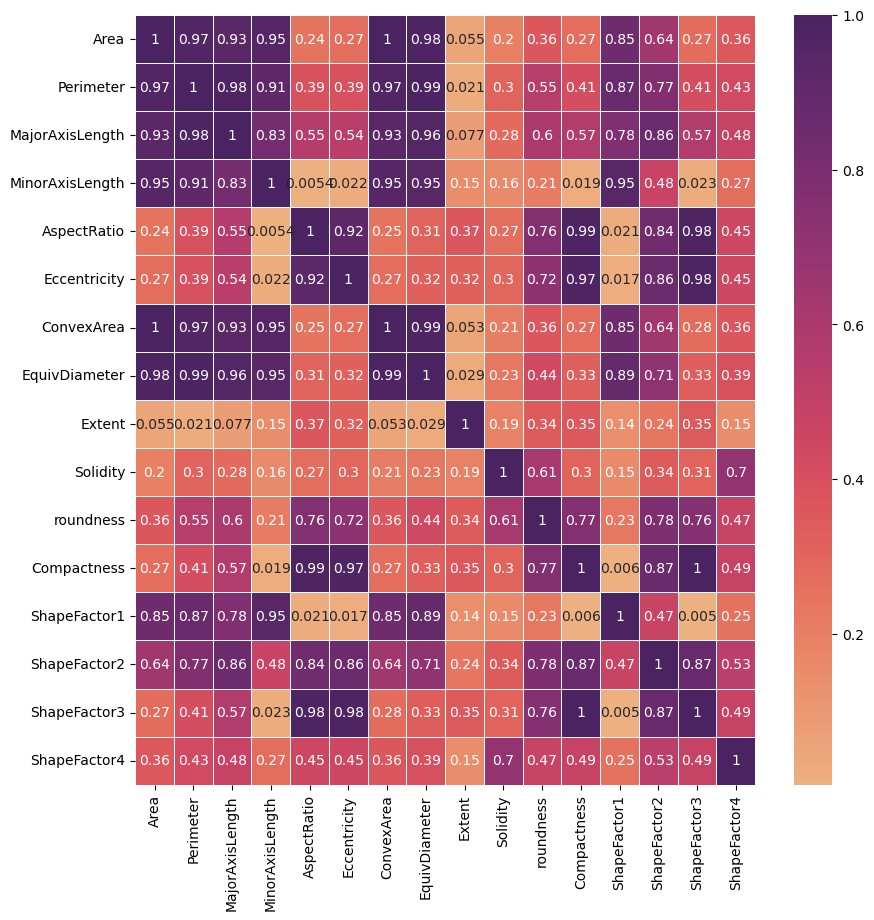

In [122]:
# CORRELATION

fig, ax = plt.subplots(figsize=(10,10)) 
CORR_MAP = df.corr(numeric_only = True).abs()
Steep = 10.0
Stretch = 2.002
if Stretch < 2.0 :
    Stretch = 2.0 
HIGH_CORR = (np.tan((np.pi/Stretch) * np.abs(CORR_MAP)) * (1 / Steep)) #LOW INFORMATION
LOW_CORR  = (np.tan((np.pi/Stretch) * (1 - np.abs(CORR_MAP))) * (1 / Steep)) #HIGH INFORMATION

sns.heatmap( CORR_MAP,annot=True,linewidths=.5, cmap="flare"); # cmap="rocket_r"
#sns.heatmap( HIGH_CORR,annot=True,linewidths=.5, cmap="flare"); # cmap="rocket_r"
#sns.heatmap( LOW_CORR,annot=True,linewidths=.5, cmap="flare"); # cmap="rocket_r"


In [123]:
# ARBITRARY DROPPING BY CORRELATION ANALYSIS
# Note: Area and ConvexArea are almost perfectly correlated: we already noticed that mathematically one is the square root of the other.
# Note: Compactness and Shape Factor 3 are almost perfectly correlated
# Proposition: Erase ConvexArea and Compactness

dfb = df.drop(['ConvexArea','Compactness'], axis=1)


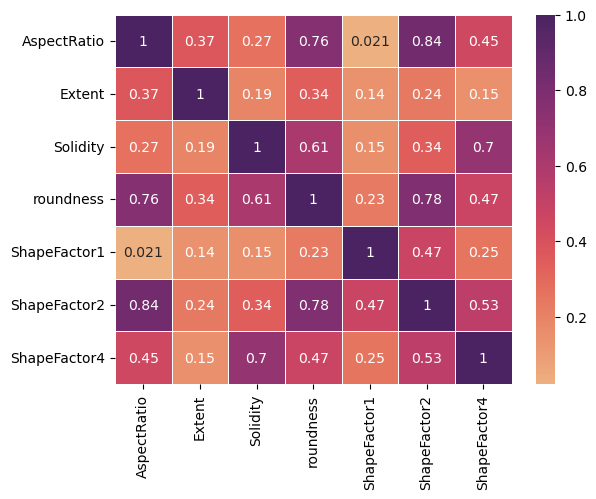

In [124]:
# PRUNING BY CORRELATION

dfc = df
corr = dfc.corr(numeric_only = True).abs()
drop = []
hold = []
p_threshold = 0.9

for i in range(0,corr.shape[0]):
    for j in range(i+1,corr.shape[1]):
        if corr.iloc[i,j]>=p_threshold:
            feature_i_corrsum = corr.iloc[i,:].sum()
            feature_j_corrsum = corr.iloc[j,:].sum()
            if feature_i_corrsum <= feature_j_corrsum:
                #hold.append(corr.index[i])
                #drop.append(corr.index[j])
                hold.append(i)
                drop.append(j)                
            else:
                #drop.append(corr.index[i])
                #hold.append(corr.index[j])
                drop.append(i)
                hold.append(j)

drop = list(set(drop))
drop = [list(corr.index)[i] for i in drop]
dfc = dfc.drop(drop, axis=1) 
corr = dfc.corr(numeric_only = True).abs()
sns.heatmap( corr,annot=True,linewidths=.5, cmap="flare"); # cmap="rocket_r"

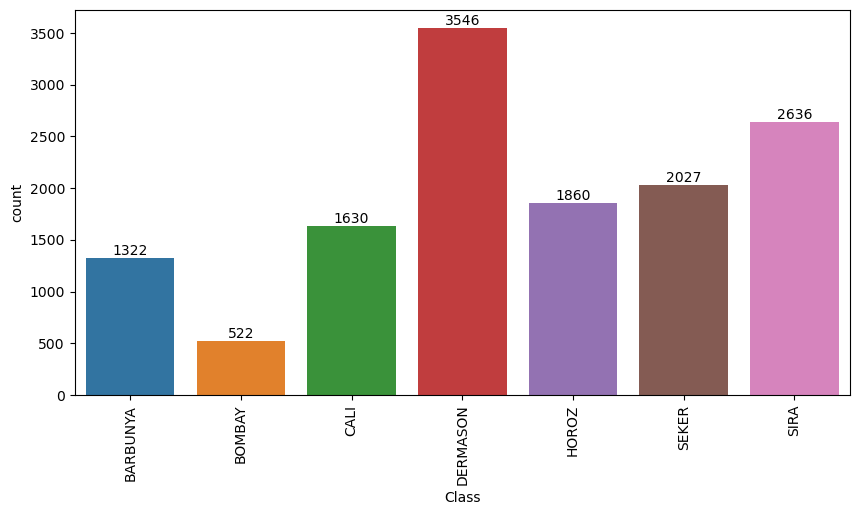

In [125]:
# CLASSES ANALYSIS

fig, ax = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax, x='Class', data=df, order=labels)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
graph.bar_label(ax.containers[0]);

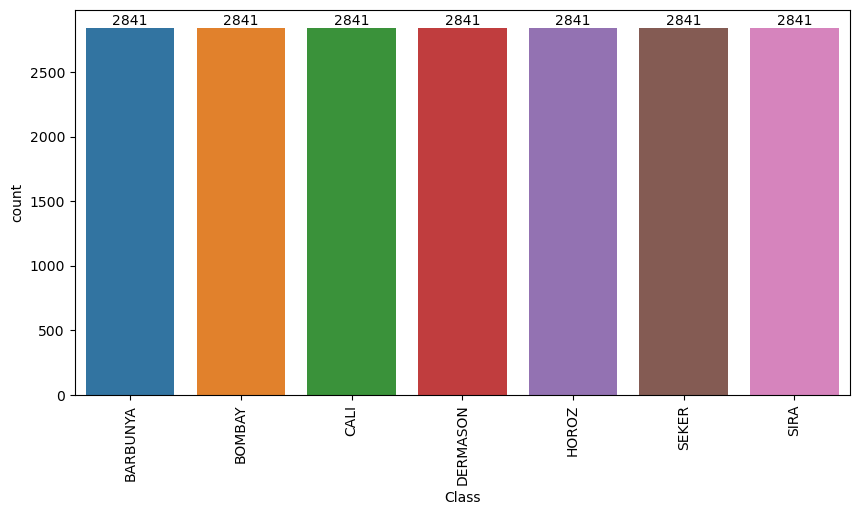

In [126]:
# OVERSAMPLING - SMOTE

X = df.iloc[:,:-1]
y = df.iloc[:,-1:]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)
smt = SMOTE()
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
df_train_smote = pd.merge(X_train_smt, y_train_smt, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax, x='Class', data=df_train_smote, order=labels)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
graph.bar_label(ax.containers[0]);

# ATTENZIONE, IL NUMERO DI ISTANZE PER CLASSE CAMBIA CONTINUAMENTE, DOPO LO SPLIT LA CLASSE CHE NE ESCE "VINCITRICE",
# LA MAGGIORMENTE SELEZIONA DETERMINA LA SOGLIA DI OVERSAMPLING


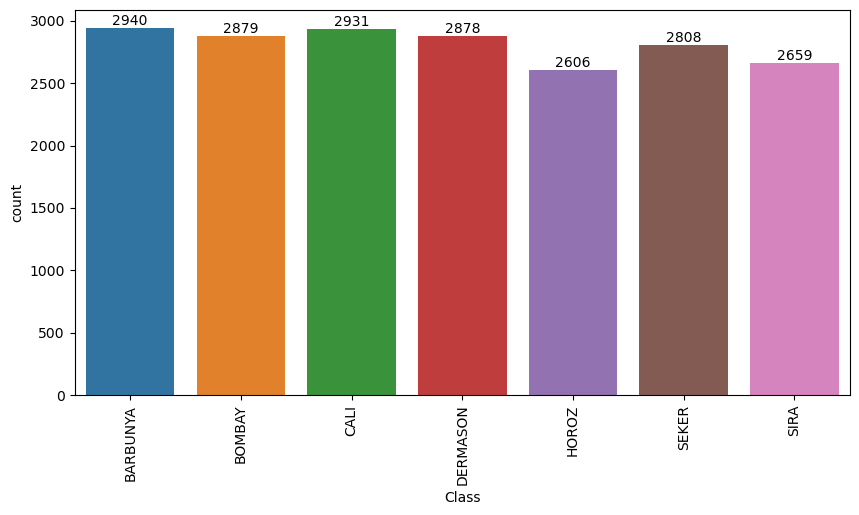

In [127]:
# OVERSAMPLING - ADASYN

X = df.iloc[:,:-1]
y = df.iloc[:,-1:]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)
ada = ADASYN()
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)
df_train_adasyn = pd.merge(X_train_ada, y_train_ada, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax, x='Class', data=df_train_adasyn, order=labels)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
graph.bar_label(ax.containers[0]);

# ATTENZIONE, IL NUMERO DI ISTANZE PER CLASSE CAMBIA CONTINUAMENTE, DOPO LO SPLIT LA CLASSE CHE NE ESCE "VINCITRICE",
# LA MAGGIORMENTE SELEZIONA DETERMINA LA SOGLIA DI OVERSAMPLING

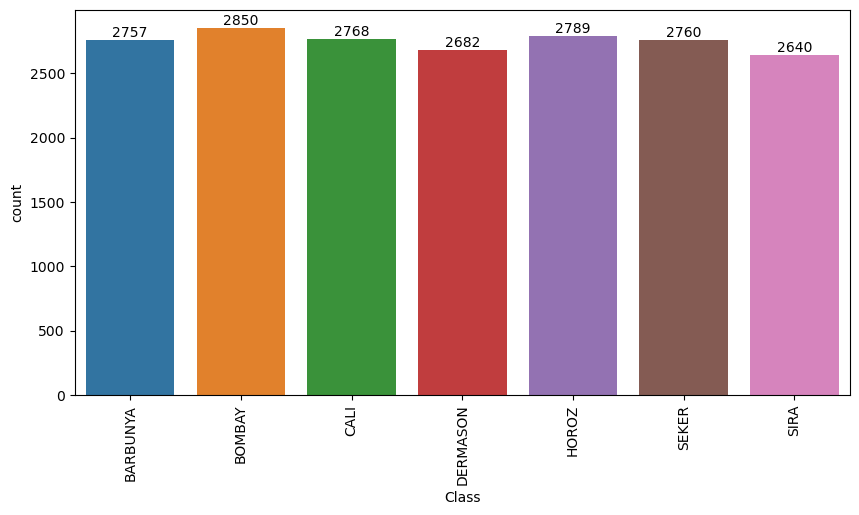

In [128]:
# HYBRIDIZATION - SMOTE+Tomek

X = df.iloc[:,:-1]
y = df.iloc[:,-1:]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)
stk = SMOTETomek()
X_train_stk, y_train_stk = stk.fit_resample(X_train, y_train)
df_train_stomek = pd.merge(X_train_stk, y_train_stk, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax, x='Class', data=df_train_stomek, order=labels)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
graph.bar_label(ax.containers[0]);

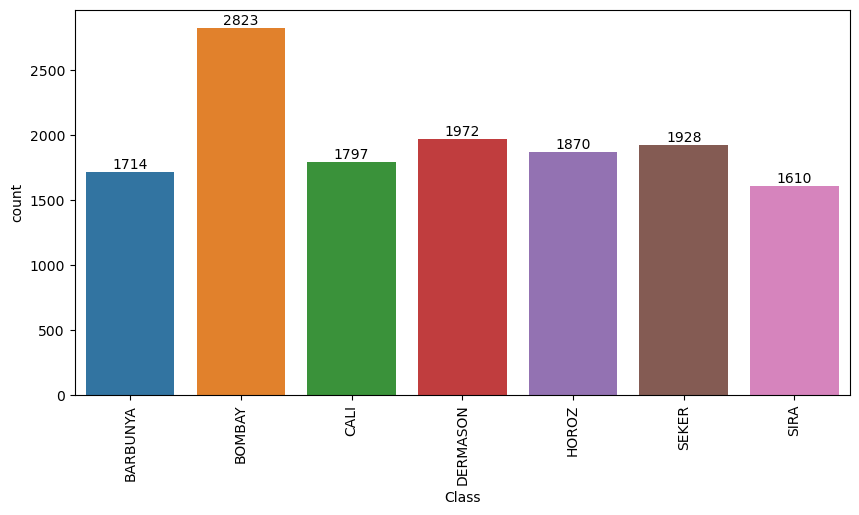

In [129]:
# HYBRIDIZATION - SMOTE+ENN

X = df.iloc[:,:-1]
y = df.iloc[:,-1:]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)
snn = SMOTEENN()
X_train_snn, y_train_snn = snn.fit_resample(X_train, y_train)
df_train_smtenn = pd.merge(X_train_snn, y_train_snn, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax, x='Class', data=df_train_smtenn, order=labels)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
graph.bar_label(ax.containers[0]);

In [130]:
#dfs = [dfc]#, df_train_smote, df_train_adasyn, df_train_stomek, df_train_smtenn]

#for item in dfs:
#    feats = item.columns.to_list()
#    pairs_features = [(a, b) for idx, a in enumerate(feats) for b in feats[idx + 1:]]
#    for pair in pairs_features:
#        plt.subplots(figsize=(10,5))
#        for label in labels:
#            sns.scatterplot(x=pair[0], y=pair[1], data=item[item['Class']==label])
#            plt.legend(labels, fontsize = 10, loc=0)
    

In [220]:
# RANDOM FORESTS

dfr = df # [df, dfb, dfc, df_train_smote, df_train_adasyn, df_train_stomek, df_train_smtenn]
X = dfr.iloc[:,:-1]
y = dfr.iloc[:,-1:]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)
#rnd_clf = RandomForestClassifier(n_estimators=512, max_leaf_nodes=16)
#rnd_clf.fit(X_train, y_train)

#y_pred_rf = rnd_clf.predict(X_test)

#test_list = np.array(y_test, ndmin=1)
#test_pred = np.array([y_pred_rf]).T
#accu = (np.sum(test_list == test_pred)/len(test_list))
#print(accu)

#fig, axes = plt.subplots(figsize=(15,15), dpi=1080)
#tree.plot_tree(rnd_clf.estimators_[1], max_depth=None, feature_names=features, class_names=labels,
#               label = 'all', filled=True, impurity=False, node_ids=False, proportion=False,
#               rounded=True, precision = 3, ax=axes, fontsize = 5);


In [225]:
models = {
    "Random Forest": RandomForestClassifier(
        min_samples_leaf=5, min_samples_split = 2
    )
}
param_grids = {
    "Random Forest": {"n_estimators": [32, 64]}
}
cv = KFold(n_splits=4, shuffle=True)

results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        cv=cv,
    ).fit(X, y)
    result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    results.append(result)

c:\Users\damar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\damar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\damar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\damar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y wa